# LinkedIn Queens Puzzle Solver

This code is for solving the LinkedIn puzzle, "Queens".

When you run it on a Mac, it will immediately ask you to select the puzzle grid with the crosshairs by clicking and dragging.

When you let go of the mouse, the screenshot saves itself, and then the program immediately runs on the image and presents you with the solved puzzle that you need to transpose into LinkedIn. 

Time taken: 0.015033 seconds


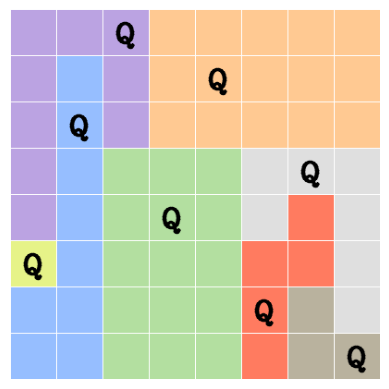

In [36]:
import cv2 as cv
import numpy as np
import math
import time
import os
from matplotlib import pyplot as plt
import random
import string
import copy

def generate_unique_identifier(length=5):
    """Generates a random string of specified length using ASCII letters.
       This is used to generate a random ID each time this code is run, so
       the code can find the screenshot that applies to this run."""
    # Pool of characters to choose from includes both lowercase and uppercase letters
    characters = string.ascii_letters
    # Randomly select characters and join them to form a string
    return ''.join(random.choice(characters) for _ in range(length))

def is_position_safe(chessboard_template, current_board, row_idx, col_idx, color_queen_map, board_size):
    """Checks if a queen can be safely placed on the board at the given row and column."""
    # Check if the left side of the current row has any queens
    for i in range(col_idx):
        if current_board[row_idx][i] == 'Q':
            return False

    # Check the upper left diagonal for any queens
    if col_idx - 1 >= 0 and row_idx - 1 >= 0:
        if current_board[row_idx-1][col_idx-1] == "Q":
            return False

    # Check the lower left diagonal for any queens
    if col_idx - 1 >= 0 and row_idx + 1 < board_size:
        if current_board[row_idx+1][col_idx-1] == "Q":
            return False

    # Check the column above the current row for any queens
    for i in range(row_idx):
        if current_board[i][col_idx] == "Q":
            return False

    # Ensure no queen is placed in a region with the same color
    cell_color = chessboard_template[row_idx][col_idx]
    if color_queen_map[cell_color]:
        return False

    # If all checks are passed, it is safe to place a queen
    return True

def solve_queens_recursively(chessboard_template, current_board, col_idx, color_queen_map, board_size):
    """Recursively tries to solve the N-Queens problem. 
        Optimization is not used here, and we opt for a greedy, brute force approach. 
        The time spent coding a solution using optimization is just not worth it as this
        already goes very fast."""
    # Base case: If all queens are placed because we reach a column thats bigger than the board, return True
    if col_idx >= board_size:
        return True

    # Try placing a queen in each row of the current column
    for i in range(board_size):
        if is_position_safe(chessboard_template, current_board, i, col_idx, color_queen_map, board_size):
            # Place the queen at the current position
            current_board[i][col_idx] = 'Q'
            # Mark the color as having a queen
            color_queen_map[chessboard_template[i][col_idx]] = True 

            # Recur to place queens in the next column
            if solve_queens_recursively(chessboard_template, current_board, col_idx + 1, color_queen_map, board_size):
                return True

            # Backtrack if no solution is found and remove the queen
            current_board[i][col_idx] = chessboard_template[i][col_idx]
            color_queen_map[chessboard_template[i][col_idx]] = False

    # If the queen cannot be placed in any row in this column, return False
    return False

def solve_n_queens_puzzle(chessboard):
    """Wrapper that attempts to solve the N-Queens puzzle and prints the board."""
    # Create a copy of the chessboard to modify
    board_copy = copy.deepcopy(chessboard)
    # Initialize a map to keep track of which colors have queens
    color_queen_map = {str(i): False for i in range(1, len(chessboard)+1)}
    
    # Attempt to solve the puzzle using backtracking
    if not solve_queens_recursively(chessboard, board_copy, 0, color_queen_map, len(chessboard)):
        print("No solution exists for the given board.")
    else:
        # Print the original and the solved board
        pass
        #print("Original Board Configuration:\n" + "\n".join([" ".join(row) for row in chessboard]))
        #print("Solved Board Configuration:\n" + "\n".join([" ".join(row) for row in board_copy]))
    
    # Return the board with placed queens
    return board_copy
    
def get_latest_file_by_modification(folder_path, identifier):
    """Retrieves the most recently modified file that includes the identifier.
        This translates to the screenshot that was just taken at the beginning
        of the code execution."""
    # List all files in the given folder that contain the identifier
    files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file)) and identifier in file]
    if not files:
        return None  # Return None if no files match the criteria

    # Find the file with the latest modification time
    latest_file = max(files, key=lambda file: os.path.getmtime(os.path.join(folder_path, file)))
    return latest_file

######## Execution 

# Generate a unique identifier for the current run
session_identifier = generate_unique_identifier()
# Define the path to the folder where the screenshot will be saved
screenshot_folder_path = "/Users/206791862/Downloads"

# Capture a screenshot and save it with the unique identifier
os.system(f"screencapture -i {screenshot_folder_path}/{session_identifier}.png")

# Retrieve the latest file that matches the run identifier
most_recent_screenshot = get_latest_file_by_modification(screenshot_folder_path, session_identifier)

# Start a timer to measure the duration of the image processing
processing_start_time = time.perf_counter()

# Read the input image from the screenshot
original_image = cv.imread(os.path.join(screenshot_folder_path, most_recent_screenshot))
# Save the original image for later reference
cv.imwrite("solution/0_original.png", original_image)

# Convert the image to grayscale to facilitate contour detection
grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
cv.imwrite("solution/1_grayscale.png", grayscale_image)

# Detect contours in the grayscale image
detected_contours, _ = cv.findContours(grayscale_image, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
# Sort the detected contours by area in descending order
sorted_contours = sorted(detected_contours, key=cv.contourArea, reverse=True)

# Assume the largest contour is the boundary of the puzzle grid; extract its bounding box
grid_x, grid_y, grid_width, grid_height = cv.boundingRect(sorted_contours[1])

# Crop the image to isolate the puzzle grid
cropped_grid_image = original_image[grid_y:grid_y+grid_height, grid_x:grid_x+grid_width]
cv.imwrite("solution/2_cropped_grid.png", cropped_grid_image)

# Convert the cropped grid image to grayscale
cropped_grayscale_grid = cv.cvtColor(cropped_grid_image, cv.COLOR_BGR2GRAY)
cv.imwrite("solution/3_cropped_grayscale_grid.png", cropped_grayscale_grid)

# Detect contours again within the cropped grayscale grid
# This minimum contour is meant to ignore when the puzzle puts a queen icon in a square
min_contour_area = 10 ** 2
grid_contours, _ = cv.findContours(cropped_grayscale_grid, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
# Filter contours by minimum area
filtered_contours = [contour for contour in grid_contours if cv.contourArea(contour) >= min_contour_area]
# Sort the filtered contours by area
filtered_contours = sorted(filtered_contours, key=cv.contourArea)

# Create a blank image to draw contours
contour_drawing = np.zeros((cropped_grayscale_grid.shape[0], cropped_grayscale_grid.shape[1], 3), dtype=np.uint8)
contour_overlay = cv.drawContours(contour_drawing, filtered_contours, -1, (0, 255, 0), 2)
cv.imwrite("solution/4_contours_overlay.png", contour_overlay)

# Calculate the total number of cells and the grid size
total_cells_count = len(filtered_contours) - 2
estimated_grid_size = int(math.sqrt(total_cells_count))

if total_cells_count != estimated_grid_size ** 2:
    print("Incomplete grid detected. Exiting process.")

# Calculate the dimensions of each cell in the grid
cell_width = grid_width // estimated_grid_size
cell_height = grid_height // estimated_grid_size

# Initialize variables to store the colors and the board configuration
distinct_colors = []
board_configuration = []
color_counter = 1
color_to_index_map = {}
index_to_color_map = {}
cell_padding = 10

# Iterate through each cell in the grid to extract color information
for row_index in range(estimated_grid_size):
    row_colors = []
    for col_index in range(estimated_grid_size):
        # Calculate the coordinates of the cell with padding
        cell_x_start = col_index * cell_width
        cell_y_start = row_index * cell_height
        padding = 15
        cell_image = cropped_grid_image[cell_y_start+padding:cell_y_start+cell_height-padding, cell_x_start+padding:cell_x_start+cell_width-padding]
        
        # Verify that the cell contains pixels
        if cell_image.size > 0:
            # Compute the median color for each channel in the cell
            median_cell_color = [int(np.median(cell_image[:, :, channel])) for channel in range(cell_image.shape[-1])]
        else:
            # Use a default color if the cell is empty
            median_cell_color = [default_color] * 3  # Replace with your default color

        median_cell_color = tuple(median_cell_color)
        
        # Assign a unique index to each distinct color
        if median_cell_color not in color_to_index_map:
            color_to_index_map[median_cell_color] = str(color_counter)
            index_to_color_map[str(color_counter)] = median_cell_color
            color_counter += 1
        row_colors.append(color_to_index_map[median_cell_color])

    # Add the row of colors to the board configuration
    board_configuration.append(row_colors)

# Attempt to solve the N-Queens puzzle with the extracted board configuration
solved_chessboard = solve_n_queens_puzzle(board_configuration)
            
# Validate the number of detected colors; if they don't match the grid size, abort
if len(color_to_index_map) != estimated_grid_size:
    print("Mismatch in the number of detected colors and grid size. Exiting process.")

# Create an image to display the solved puzzle
solved_puzzle_image = np.ones((grid_height, grid_width, 3), dtype="uint8") * 255  # White background

# Define sizes for drawing the grid and the queens
grid_border_thickness = 1
queen_text_size = 1  # Scale for text size

# Draw the solved board on the image
for row_index in range(estimated_grid_size):
    for col_index in range(estimated_grid_size):
        # Compute the top-left corner of the cell
        cell_x_start = col_index * cell_width
        cell_y_start = row_index * cell_height
        # Retrieve the color assigned to the current cell
        cell_color_value = index_to_color_map.get(board_configuration[row_index][col_index])
        cell_color = (int(cell_color_value[0]), int(cell_color_value[1]), int(cell_color_value[2]))
        
        # Fill the cell with its color
        cv.rectangle(solved_puzzle_image, 
                     (cell_x_start + grid_border_thickness, cell_y_start + grid_border_thickness), 
                     (cell_x_start + cell_width - grid_border_thickness, cell_y_start + cell_height - grid_border_thickness), 
                     cell_color, 
                     thickness=cv.FILLED)
        
        # If the current cell is marked with a queen, draw the letter "Q"
        if solved_chessboard[row_index][col_index] == "Q":
            text_size = cv.getTextSize("Q", cv.FONT_HERSHEY_COMPLEX, queen_text_size, thickness=2)[0]
            text_x = cell_x_start + (cell_width - text_size[0]) // 2
            text_y = cell_y_start + (cell_height + text_size[1]) // 2
            cv.putText(solved_puzzle_image, "Q", 
                       (text_x, text_y), 
                       cv.FONT_HERSHEY_COMPLEX, 
                       queen_text_size, 
                       (0, 0, 0), 
                       thickness=2, 
                       lineType=cv.LINE_AA)

# Save the final image with the solved puzzle
cv.imwrite("solution/solved_puzzle.png", solved_puzzle_image)

# Measure the elapsed time for the entire process
processing_end_time = time.perf_counter()
elapsed_time = processing_end_time - processing_start_time
print(f'Time taken: {elapsed_time:.6f} seconds')

# Display the solved puzzle image in a notebook
solved_puzzle_image_rgb = cv.cvtColor(solved_puzzle_image, cv.COLOR_BGR2RGB)
plt.imshow(solved_puzzle_image_rgb)
plt.axis('off')  # Hide the axis for a cleaner display
plt.show()
